In [1]:
import kenlm
import multiprocessing, os, sys
import numpy as np
import subprocess
import matplotlib.pyplot as plt
sys.path.append('../')
%load_ext autoreload
%autoreload 2

## use kenlm to generate scores

In [7]:
class KenlmWrapper(object):
    def __init__(self, model):
        self.model = model
        self.clear()
    
    def clear(self):
        self.score_accum = 0
        self.last_state = kenlm.State()
        self.new_state = kenlm.State()
        return self
    
    def init(self):
        self.clear()
        self.model.BeginSentenceWrite(self.last_state)
        return self
    
    def next_score(self, word):
        s = self.model.BaseScore(self.last_state, word, self.new_state)
        self.score_accum += s
        tmp = self.last_state
        self.last_state = self.new_state
        self.new_state = tmp
        return s

In [8]:
def _lm_examine(args):
    filepath, out_filepath, model, ind, start, end = args
    kenlm_wrapper = KenlmWrapper(model)
    out_filepath = '{}.{}'.format(out_filepath, ind)
    with open(filepath, 'r') as fin, open(out_filepath, 'w') as fout:
        for i, l in enumerate(fin):
            if i < start:
                continue
            if i >= end:
                break
            words = l.strip().split()
            if len(words) == 0:
                continue
            kenlm_wrapper.init().next_score(words[0]) # initialize the sentence
            for word in words[1:]:
                score = kenlm_wrapper.next_score(word) # calculate score
                fout.write('{:.5f}\n'.format(score))
def lm_examine(filepath, out_filepath, model_path, num_thread=4):
    model = kenlm.LanguageModel(model_path)
    num_lines = sum(1 for l in open(filepath, 'r'))
    print('num lines {}'.format(num_lines))
    batch_size = int(np.ceil(num_lines / num_thread))
    with multiprocessing.Pool(num_thread) as p:
        print(p.map(_lm_examine, [(filepath, out_filepath, model, i, i*batch_size, i*batch_size+batch_size) 
                                  for i in range(num_thread)]))

In [47]:
lm_examine(os.path.join('/usr0/home/zhengbaj/data/',
                        'lm/1-billion-word-language-modeling-benchmark-r13output',
                        'training-monolingual.tokenized.shuffled',
                        'news.en-00001-of-00100'),
           '1b_lm_examine', '1b.binary', num_thread=4)
subprocess.run("cat 1b_lm_examine.{0..3} > 1b_lm_examine", shell=True, executable='/bin/bash', check=True)

num lines 306068
[None, None, None, None]


CompletedProcess(args='cat 1b_lm_examine.{0..3} > 1b_lm_examine', returncode=0)

## kenlm test

In [36]:
def kenlm_test():
    model = kenlm.LanguageModel('1b.binary')
    kenlm_wrapper = KenlmWrapper(model)
    kenlm_wrapper.init()
    print(kenlm_wrapper.next_score('i'))
    print(kenlm_wrapper.next_score('have'))
    print(kenlm_wrapper.next_score('a'))
    print(kenlm_wrapper.next_score('lot'))
    print(kenlm_wrapper.next_score('of'))
    print(kenlm_wrapper.next_score('voices'))
kenlm_test()

-5.992492198944092
-1.5513503551483154
-0.9852211475372314
-2.0829129219055176
-0.31264644861221313
-4.039732933044434


In [ ]:
9.384115219116211

## visualize the histogram of scores

In [62]:
def hist_score(filepath, num_bins=100, cut_percentile=10):
    scores = np.array(list(map(lambda x: float(x), open(filepath, 'r').read().split())))
    n, bins, patches = plt.hist(scores, num_bins, facecolor='blue', cumulative=True, normed=True)
    plt.show()
    cut_value = cut_percentile / 100
    for i in range(len(n)):
        if n[i] >= cut_value:
            return bins[i+1]

/usr1/home/zhengbaj/exp/env_python3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


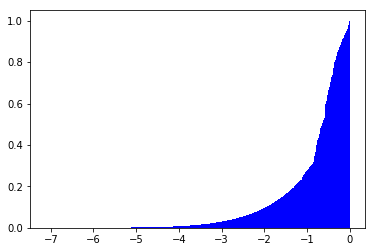

-2.5663104

In [63]:
hist_score('1b_lm_examine', num_bins=500, cut_percentile=5)

## split document using kenlm and the threshold

In [24]:
from utils import load_prep_file, load_prep_file_aslist, save_prep_file, Vocab

In [15]:
data_dir = '../data/bing'
doc_filepath = os.path.join(data_dir, 'docs.prep')
vocab_filepath = os.path.join(data_dir, 'vocab')
file_format = 'ir'

In [67]:
def split_document(model_path, doc_filepath, vocab_filepath, file_format, out_filepath, thres):
    '''
    Two files are saved. One is segmentation file.
    The other one stores actual segmented word sequence for debugging and investigation.
    '''
    model = kenlm.LanguageModel(model_path)
    kenlm_wrapper = KenlmWrapper(model)
    docs = load_prep_file_aslist(doc_filepath, file_format=file_format, use_split=True)
    #docs = load_prep_file(doc_filepath, file_format=file_format)
    docs_seg = []
    docs_seg_debug = []
    vocab = Vocab(filepath=vocab_filepath, file_format=file_format)
    print('start spliting')
    for i, (k, inds) in enumerate(docs):
        if i % 50000 == 0:
            print(i/50000)
        words = vocab.decode(inds)
        seg = [1]
        seg_debug = ['|', words[0]]
        kenlm_wrapper.init().next_score(words[0]) # first word
        for word in words[1:]:
            score = kenlm_wrapper.next_score(word)
            if score >= thres:
                seg.append(0)
                seg_debug.append(word)
            else:
                seg.append(1)
                kenlm_wrapper.init().next_score(word)
                seg_debug.append('|')
                seg_debug.append(word)
        docs_seg.append((k, seg))
        docs_seg_debug.append((k, seg_debug))
    save_prep_file(out_filepath, docs_seg, file_format=file_format)
    save_prep_file(out_filepath + '.debug', docs_seg_debug, file_format=file_format)

In [37]:
%%capture output
split_document('1b.binary', doc_filepath, vocab_filepath, file_format=file_format, 
               out_filepath='docs_seg.prep', thres=-2.56)

## visualize split length

In [ ]:
def split_length(seg_filepath, file_format):
    MAX_LEN = 50
    doc_seg = load_prep_file_aslist(seg_filepath, file_format=file_format, use_split=True)
    seg_len_all = []
    seg_len_avg_per_doc = []
    for k, seg in doc_seg:
        ind = -1
        seg_len_cur_doc = []
        for i, s in enumerate(seg[1:] + [1]):
            if s == 1:
                cur_len = i - ind
                ind = i
                if cur_len > MAX_LEN:
                    #print(k, cur_len)
                    continue
                seg_len_all.append(cur_len)
                seg_len_cur_doc.append(cur_len)
        seg_len_avg_per_doc.append(np.mean(seg_len_cur_doc))
    max_seq_len = np.max(seg_len_all)
    min_seq_len = np.min(seg_len_all)
    print('max seg len: {}, min: {}'.format(max_seq_len, min_seq_len))
    n, bins, patches = plt.hist(seg_len_all, MAX_LEN-1, facecolor='blue', cumulative=False, density=False)
    print(list(zip(range(1, MAX_LEN+1), map(int, n))))
    print(bins)
    plt.show()

max seg len: 50, min: 1
[(1, 76194048), (2, 32670397), (3, 11743670), (4, 4531826), (5, 2433412), (6, 1281292), (7, 711649), (8, 375740), (9, 207113), (10, 114441), (11, 64746), (12, 40314), (13, 21968), (14, 13030), (15, 8183), (16, 4592), (17, 2994), (18, 2089), (19, 1218), (20, 866), (21, 581), (22, 454), (23, 331), (24, 233), (25, 173), (26, 164), (27, 104), (28, 125), (29, 66), (30, 99), (31, 76), (32, 59), (33, 108), (34, 32), (35, 34), (36, 18), (37, 24), (38, 14), (39, 41), (40, 7), (41, 21), (42, 17), (43, 16), (44, 7), (45, 6), (46, 2), (47, 3), (48, 5), (49, 10)]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


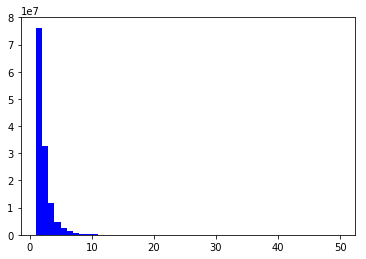

In [71]:
split_length('docs_seg.prep', file_format=file_format)